# morph-var 3

## Build, train and test a landform profile shape classifier using user-chosen classes

## Packages and libraries

In [77]:
import numpy as np
import pandas as pd
from geomdl import BSpline, utilities
from scipy import linalg
import itertools
import matplotlib.pyplot as plt
import os
from sklearn import svm
import sklearn
from sklearn import preprocessing
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [78]:
# Define a function to load the coordinates from the cropped and normalized landform profiles.
def load_data(class_name,path):
    #Set path to folder with 2-D cropped and normalized profiles.
    data_x_temp = []
    data_y_temp = []
    filenames =class_name #select profiles that belong to the desired class training group.
    for file in filenames:
            # Load x-coordinate data from files matching regular expression for desired class
            data_x_temp.append(pd.read_csv(path+"/"+file).iloc[:,1].values)
            # Load y-coordinate data from files matching regular expression for desired class
            data_y_temp.append(pd.read_csv(path+"/"+file).iloc[:,2].values)
            
    # Create dataframes for x and y
    dataclass_x = pd.DataFrame(data_x_temp).transpose() 
    dataclass_y = pd.DataFrame(data_y_temp).transpose()
    dataclass_x.columns = filenames
    dataclass_y.columns = filenames

    return dataclass_x, dataclass_y

In [79]:
# pip install geomdl

In [80]:
# %matplotlib qt

## Define landform profile morphologic classes

Using field observations and expert knowledge, define morphologic classes and select a dataset of manually classified profiles to train the classifier.

In [81]:
# #Specify the number of morphologic classes
# n_classes = 6

# #For each class, list the filenames (strings) of the selected profiles to represent each class.
# class1='VogarA_cropnorm_146.txt','VogarA_cropnorm_95.txt','VogarA_cropnorm_98.txt','VogarA_cropnorm_2.txt','Stora_Aragja_cropnorm_1.txt','Stora_Aragja_cropnorm_2.txt','Stora_Aragja_cropnorm_4.txt','Stora_Aragja_cropnorm_32.txt','Stora_Aragja_cropnorm_40.txt','Sodulholagja_cropnorm_18.txt','Sodulholagja_cropnorm_28.txt','RHPS_cropnorm_190.txt','RHPS_cropnorm_193.txt','RHPS_cropnorm_195.txt','RHPS_cropnorm_208.txt','VogarA_cropnorm_68.txt','RHPS_cropnorm_210.txt'
# class2='VogarA_cropnorm_129.txt','VogarA_cropnorm_131.txt','VogarA_cropnorm_133.txt','VogarA_cropnorm_134.txt','VogarA_cropnorm_135.txt','VogarA_cropnorm_137.txt','VogarA_cropnorm_138.txt','VogarA_cropnorm_139.txt','VogarA_cropnorm_140.txt','VogarA_cropnorm_38.txt','VogarA_cropnorm_50.txt','VogarA_cropnorm_47.txt','VogarA_cropnorm_46.txt','VogarA_cropnorm_57.txt','VogarA_cropnorm_56.txt','VogarA_cropnorm_55.txt','VogarA_cropnorm_53.txt','VogarA_cropnorm_51.txt','Stora_Aragja_cropnorm_34.txt','Stora_Aragja_cropnorm_35.txt','Stora_Aragja_cropnorm_54.txt','Stora_Aragja_cropnorm_55.txt'
# class3='LVBD-A_4_cropnorm_300.txt','LVBD-A_4_cropnorm_302.txt','LVBD-A_4_cropnorm_316.txt','LVBD-A_4_cropnorm_335.txt','LVBD-A_4_cropnorm_317.txt','LVBD-A_4_cropnorm_340.txt','LVBD-A_4_cropnorm_355.txt','LVBD-A_4_cropnorm_365.txt','LVBD-A_4_cropnorm_375.txt','LVBD-A_4_cropnorm_385.txt','LVBD-A_4_cropnorm_390.txt','LVBD-A_4_cropnorm_535.txt','LVBD-A_4_cropnorm_540.txt','LVBD-A_4_cropnorm_590.txt','LVBD-A_4_cropnorm_630.txt','LVBD-A_4_cropnorm_760.txt','LVBD-A_4_cropnorm_770.txt','VogarA_cropnorm_118.txt','VogarA_cropnorm_78.txt','Stora_Aragja_cropnorm_9.txt','Stora_Aragja_cropnorm_15.txt'
# class4='VogarA_cropnorm_30.txt','VogarA_cropnorm_33.txt','VogarA_cropnorm_35.txt','VogarA_cropnorm_41.txt','VogarA_cropnorm_61.txt','VogarA_cropnorm_63.txt','VogarA_cropnorm_64.txt','LVBD-A_1_cropnorm_136.txt','LVBD-A_1_cropnorm_145.txt','LVBD-A_1_cropnorm_147.txt','LVBD-A_1_cropnorm_155.txt','LVBD-A_1_cropnorm_275.txt','LVBD-A_1_cropnorm_276.txt','Stora_Aragja_cropnorm_41.txt','Stora_Aragja_cropnorm_60.txt','Sodulholagja_cropnorm_37.txt','Sodulholagja_cropnorm_38.txt','RHPS_cropnorm_140.txt','RHPS_cropnorm_430.txt'
# class5='LVBD-A_1_cropnorm_96.txt','LVBD-A_1_cropnorm_410.txt','LVBD-A_1_cropnorm_570.txt','LVBD-A_1_cropnorm_575.txt','LVBD-A_1_cropnorm_650.txt','LVBD-A_1_cropnorm_690.txt','LVBD-A_4_cropnorm_0.txt','LVBD-A_4_cropnorm_5.txt','LVBD-A_4_cropnorm_7.txt','LVBD-A_4_cropnorm_11.txt','LVBD-A_4_cropnorm_210.txt','LVBD-A_4_cropnorm_225.txt','LVBD-A_4_cropnorm_515.txt','Stora_Aragja_cropnorm_6.txt','Stora_Aragja_cropnorm_67.txt','RHPS_cropnorm_20.txt','RHPS_cropnorm_60.txt','RHPS_cropnorm_65.txt'
# class6='VogarA_cropnorm_26.txt','VogarA_cropnorm_28.txt','LVBD-A_1_cropnorm_100.txt','LVBD-A_1_cropnorm_101.txt','LVBD-A_1_cropnorm_102.txt','LVBD-A_1_cropnorm_104.txt','LVBD-A_1_cropnorm_106.txt','LVBD-A_1_cropnorm_114.txt','LVBD-A_1_cropnorm_117.txt','LVBD-A_1_cropnorm_130.txt','LVBD-A_1_cropnorm_164.txt','LVBD-A_1_cropnorm_166.txt','LVBD-A_1_cropnorm_167.txt','LVBD-A_1_cropnorm_450.txt','LVBD-A_1_cropnorm_800.txt','LVBD-A_1_cropnorm_854.txt','LVBD-A_4_cropnorm_150.txt','LVBD-A_4_cropnorm_155.txt','LVBD-A_4_cropnorm_151.txt','Stora_Aragja_cropnorm_44.txt','Stora_Aragja_cropnorm_51.txt','Stora_Aragja_cropnorm_58.txt','Stora_Aragja_cropnorm_59.txt','Stora_Aragja_cropnorm_64.txt','Stora_Aragja_cropnorm_68.txt','Sodulholagja_cropnorm_26.txt','RHPS_cropnorm_397.txt','RHPS_cropnorm_500.txt'

In [82]:
#Set path to that of the output files from process-profiles
# path= "./All_2D_cropped_normalized"
path=r'C:\Users\user\Desktop\地形数据分析\result\profile_shapefile\DE001_cropped_normalized_profiles'

In [83]:
import os  
import random 
folder_path = r'C:\Users\user\Desktop\地形数据分析\result\profile_shapefile\DE001_cropped_normalized_profiles'  
def is_file_empty(filepath):  
    """Check if the file is empty (based on content)"""  
    try:  
        with open(filepath, 'r', encoding='utf-8') as file:  
            # Read and skip the first line 
            for _ in range(5):  
                file.readline()  
            # Read the second line and remove the leading and trailing spaces  
            second_line = file.readline().strip()  
            # Check if the second line only contains commas and optional spaces  
            return second_line.replace(' ', '').replace(',', '').replace('', '') == ''  
    except Exception as e:  
        print(f"Error reading file {filepath}: {e}")  
        return True    
  
# Use functions to check files  
# Get a list of all files in the folder  
filenames = [f for f in os.listdir(folder_path) if f.endswith('.txt')] 
non_empty_filenames = [f for f in filenames if not is_file_empty(os.path.join(folder_path, f))]  
  
 
  
# Randomly shuffle the list of file names to ensure randomness in allocation   
# random.seed(1)    
random.shuffle(non_empty_filenames)  
  
# Define the number of categories and the number of files that each category should contain as much as possible  
num_classes = 6  
# files_per_class = len(filenames) // num_classes  
# remainder = len(filenames) % num_classes    
files_per_class = len(non_empty_filenames) // num_classes  
remainder = len(non_empty_filenames) % num_classes  
    
# Initialize an empty list to store tuples of file names for all categories  
classes_tuples = []  
  
# Assign file names to various categories  
index = 0  
for i in range(num_classes):  
    # Assign a fixed number of files to each category first 
    class_files = filenames[index:index + files_per_class]  
    index += files_per_class  
      
    # f the current category is the last category and there are remaining files, add all remaining files to that category 
    if i == num_classes - 1 and remainder > 0:  
        class_files.extend(filenames[index:index + remainder])  
      
    # Convert the list to a tuple and add it to the category list  
    classes_tuples.append(tuple(class_files))  
  
  
# Reference these tuples with variable names  
class1, class2, class3, class4, class5, class6 = classes_tuples  
  

# Load profile data for each class
(data1_x, data1_y) = load_data(class1,path)
(data2_x, data2_y) = load_data(class2,path)
(data3_x, data3_y) = load_data(class3,path)
(data4_x, data4_y) = load_data(class4,path)
(data5_x, data5_y) = load_data(class5,path)
(data6_x, data6_y) = load_data(class6,path)

#Define 2 matrices with the positional data of profiles
M = pd.concat([data1_x, data2_x, data3_x,data4_x, data5_x, data6_x],axis=1)
Z = pd.concat([data1_y, data2_y, data3_y,data4_y, data5_y,data6_y],axis=1)
names=list(M.columns)

empty_names=[]
new_filenames = []
for a in names:
    if len(M[a].dropna())<=3:
        empty_names.append(a)
        # print (f"Appending {a}")
    else:
        new_filenames.append(a)
        continue 
        
files_per_class = len(new_filenames) // num_classes  
remainder = len(new_filenames) % num_classes  
    
# Initialize an empty list to store tuples of file names for all categories  
classes_tuples = []  
index = 0  
for i in range(num_classes):  
      
    class_files = new_filenames[index:index + files_per_class]  
    index += files_per_class  
        
    if i == num_classes - 1 and remainder > 0:  
        class_files.extend(new_filenames[index:index + remainder])  
      
    # Convert the list to a tuple and add it to the category list  
    classes_tuples.append(tuple(class_files))  
  
# Reference these tuples with variable names 
class1, class2, class3, class4, class5, class6 = classes_tuples  
  
  

## Load normalized landform profile data

Load the 2-D coordinates of the cropped and normalized profiles (output of process-profiles) for each class list. 

In [84]:

# Load profile data for each class
(data1_x, data1_y) = load_data(class1,path)
(data2_x, data2_y) = load_data(class2,path)
(data3_x, data3_y) = load_data(class3,path)
(data4_x, data4_y) = load_data(class4,path)
(data5_x, data5_y) = load_data(class5,path)
(data6_x, data6_y) = load_data(class6,path)

In [85]:
#Determine length of each class list, as well as total length of training dataset.
len1 = len(data1_x.columns)
len2 = len(data2_x.columns)
len3 = len(data3_x.columns)
len4 = len(data4_x.columns)
len5 = len(data5_x.columns)
len6 = len(data6_x.columns)

total_len = len1+len2+len3+len4+len5+len6

In [86]:
#Define 2 matrices with the positional data of profiles
M = pd.concat([data1_x, data2_x, data3_x,data4_x, data5_x, data6_x],axis=1)
Z = pd.concat([data1_y, data2_y, data3_y,data4_y, data5_y,data6_y],axis=1)
names=list(M.columns)

empty_names=[]
new_names = []
for a in names:
    if len(M[a].dropna())<=3:
        empty_names.append(a)
        # print (f"Appending {a}")
    else:
        new_names.append(a)
        continue 
        


## Fit B-spline to profile data



In [87]:
x = []
y = []
k = []
# Define the parametric values at which the curvature will be evaluated, between 0 and 1. 
U = pd.Series(np.linspace(0,1,300))

# zip M_temp and Z_temp to create list of tuples of point
L=pd.DataFrame([list(zip(M[a].dropna(),Z[a].dropna())) for a in names]).transpose()
L.columns=names
new_names =[]
# For each profile, fit the data with a B-spline, calculate its derivatives, calculate curvature.
for a in names:
    curve = BSpline.Curve()# define the BSpline curve
    curve.degree = 3# define the degree of the curve
    # curve.ctrlpts=list(L[a].dropna())
    ctrl_pts = list(L[a].dropna())  # Attempt to extract non null values from L [a] as control points 
    # Check if ctrlpts is empty  
    if not ctrl_pts:  
        print(f"Warning: No valid control points found for index {a}. Skipping...")  
          
        continue  # Skip the current iteration  
  
    # Check if the number of control points is sufficient  
    if len(ctrl_pts) < curve.degree + 1:  
        # You can choose to throw an exception here (if you still consider it a serious issue), or take other recovery measures    
        print(f"Warning: Not enough control points ({len(ctrl_pts)}) for degree {curve.degree} at index {a}. Skipping...")  
        continue  # Alternatively, instead of continuing, set a default control point list for curve.ctrlpts 
    new_names.append(a)
    curve.ctrlpts = ctrl_pts
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts)) # auto-generate knot vector
    curve.evaluate() # evaluate curve
    # Calculate x,y coordinates and derivatives of curve at u values
    x_temp = []
    y_temp = []
    k_temp = []
    for i in U:
        ders = curve.derivatives(i, order = 2) # calculate 1st and 2nd derivatives of the curve at u, returns 3 tuples defined below.
        x_temp2 = ders[0][0] # x-position at u
        y_temp2 = ders[0][1] # y-position at u
        der1x_2 = ders[1][0] # 1st derivative with respect to x
        der1y_2 = ders[1][1] # 1st derivative with respect to y
        der2x = ders[2][0] # 2nd derivative with respect to x
        der2y = ders[2][1] # 2nd derivative with respect to y
        k_temp2 = ((der1x_2*der2y)-(der1y_2*der2x))/((((der1x_2)**2)+((der1y_2)**2))**(3/2)) # calculate curvature using formula for parametric curves.
        x_temp.append(x_temp2)
        y_temp.append(y_temp2)
        k_temp.append(k_temp2)
    x.append(x_temp)
    y.append(y_temp)
    k.append(k_temp)
    
x=pd.DataFrame(x).transpose()
x.columns=new_names
y=pd.DataFrame(y).transpose()
y.columns=new_names
k=pd.DataFrame(k).transpose()
k.columns=new_names

In [88]:
# x=pd.DataFrame(x).transpose()
# x.columns=new_names
# y=pd.DataFrame(y).transpose()
# y.columns=new_names
# k=pd.DataFrame(k).transpose()
# k.columns=new_names

## Singular value decomposition

In [89]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [90]:
features=pd.DataFrame([pd.concat([x[a],y[a]]).reset_index(drop=True) for a in new_names]).transpose()
n_features, n_samples = features.shape
mean = pd.Series(np.mean(features, axis=1))
centered_data = pd.DataFrame([features[a]-mean for a in new_names]).transpose()
U, S, V = linalg.svd(centered_data,full_matrices=False)

Text(0, 0.5, 'Percent of variance explained by component')

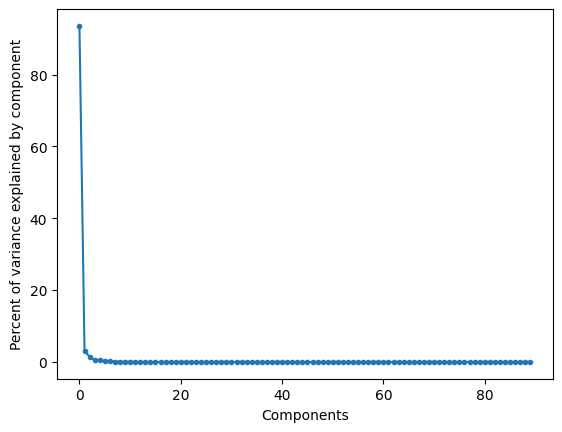

In [91]:
percent_variance = (S*100)/(S.sum())
fig,ax = plt.subplots()
ax.plot(percent_variance,marker='.')
ax.set_xlabel('Components')
ax.set_ylabel('Percent of variance explained by component')

In [92]:
one = np.ones((len1,))
two = np.ones((len2,))*2
three = np.ones((len3,))*3
four = np.ones((len4,))*4
five = np.ones((len5,))*5
six = np.ones((len6,))*6

classes= np.concatenate((one,two,three,four,five,six), axis=0)

In [93]:
proj=V.T*S
proj=pd.DataFrame(proj)

In [94]:
x_ax=0
y_ax=1
z_ax=2

v11 = np.array(proj.iloc[0:len1,x_ax])
v12 = np.array(proj.iloc[0:len1,y_ax])
v13 = np.array(proj.iloc[0:len1,z_ax])
v21 = np.array(proj.iloc[len1:len1+len2,x_ax])
v22 = np.array(proj.iloc[len1:len1+len2,y_ax])
v23 = np.array(proj.iloc[len1:len1+len2,z_ax])
v31 = np.array(proj.iloc[len1+len2:len1+len2+len3,x_ax])
v32 = np.array(proj.iloc[len1+len2:len1+len2+len3,y_ax])
v33 = np.array(proj.iloc[len1+len2:len1+len2+len3,z_ax])
v41 = np.array(proj.loc[len1+len2+len3:len1+len2+len3+len4,x_ax])
v42 = np.array(proj.loc[len1+len2+len3:len1+len2+len3+len4,y_ax])
v43 = np.array(proj.loc[len1+len2+len3:len1+len2+len3+len4,z_ax])
v51 = np.array(proj.loc[len1+len2+len3+len4:len1+len2+len3+len4+len5,x_ax])
v52 = np.array(proj.loc[len1+len2+len3+len4:len1+len2+len3+len4+len5,y_ax])
v53 = np.array(proj.loc[len1+len2+len3+len4:len1+len2+len3+len4+len5,z_ax])
v61 = np.array(proj.loc[len1+len2+len3+len4+len5:len1+len2+len3+len4+len5+len6,x_ax])
v62 = np.array(proj.loc[len1+len2+len3+len4+len5:len1+len2+len3+len4+len5+len6,y_ax])
v63 = np.array(proj.loc[len1+len2+len3+len4+len5:len1+len2+len3+len4+len5+len6,z_ax])

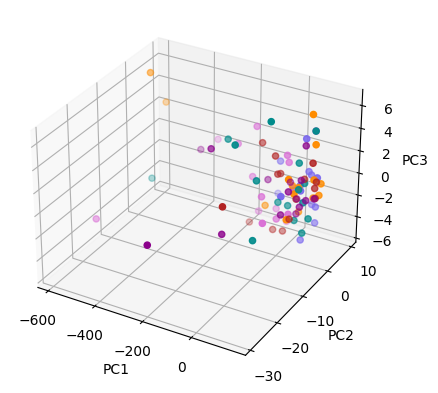

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(v11,v12,v13, c='firebrick',marker='o')
ax.scatter(v21,v22,v23,c='darkorange', marker='o')
ax.scatter(v31,v32,v33,c='darkmagenta', marker='o')
ax.scatter(v41,v42,v43,c='orchid', marker='o')
ax.scatter(v51,v52,v53,c='darkcyan', marker='o')
ax.scatter(v61,v62,v63,c='mediumslateblue', marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#ax.set_title('Projection of data into principal component space')
plt.show()

### Train classifier

#### Optimize number of modes for SVM classification

In [96]:
gamma=np.logspace(-9, 3, 13)
C=np.logspace(-3, 9, 13)
PC=list(range(1,total_len+1))

In [97]:
product_C_gamma=list(itertools.product(C,gamma))
product_PC_C_gamma=list(itertools.product(PC,product_C_gamma))

In [ ]:
accuracy_optimization_svm=[]
for a in product_PC_C_gamma:
    R=a[0]
    K=a[1][0]
    g=a[1][1]
    
    X = proj.iloc[:,:R]
    scaler = preprocessing.StandardScaler().fit(X)
    X=scaler.transform(X)
    Y = classes
            #accuracy
    rbf = svm.SVC(kernel='rbf', C=K, gamma=g,decision_function_shape='ovr')
    scores = sklearn.model_selection.cross_val_score(rbf, X, Y, cv = 5)
        
    accuracy_optimization_svm_temp=np.mean(scores) 
    accuracy_optimization_svm.append(accuracy_optimization_svm_temp) 

In [99]:
max(accuracy_optimization_svm)

0.3111111111111111

In [100]:
best_parameters=product_PC_C_gamma[accuracy_optimization_svm.index(max(accuracy_optimization_svm))]

In [101]:
best_parameters

(4, (1000000000.0, 0.0001))

In [120]:
# r_best=best_parameters[0]
r_best=7
C_best=best_parameters[1][0]
gamma_best=best_parameters[1][1]

### Cross-validation SVM


In [121]:
cv=5
f1Score=pd.DataFrame()
precision=pd.DataFrame()
recall=pd.DataFrame()
support=pd.DataFrame()
accuracy=pd.DataFrame()
cKappa=pd.DataFrame()
MCC=pd.DataFrame()

X = proj.iloc[:,0:r_best]
Y = classes

for a in range(0,cv): 
            # Split the data filenames into a training set and a testing set (67/33 split)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y,test_size = 0.30)
    
            #classification
    classifier = svm.SVC(kernel='rbf', C=C_best,gamma=gamma_best, decision_function_shape='ovr')  
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
            
    #Cohen's kappa and Matthews correlation coefficient
    cKappaTemp=sklearn.metrics.cohen_kappa_score(y_test,y_pred)
    MCCTemp=sklearn.metrics.matthews_corrcoef(y_test,y_pred)

    #CLassification stats
    classReport=sklearn.metrics.classification_report(y_test,y_pred,output_dict=True)
    classification_Report=pd.DataFrame.from_dict(classReport)
    f1ScoreTemp=classification_Report.iloc[0,:]
    precisionTemp=classification_Report.iloc[1,:]
    recallTemp=classification_Report.iloc[2,:]
    supportTemp=classification_Report.iloc[3,:]
    accuracyTemp=sklearn.metrics.accuracy_score(y_test,y_pred)
    
    #Store info for the run into dataframes
    f1Score[a]=pd.Series(f1ScoreTemp)
    precision[a]=pd.Series(precisionTemp)
    recall[a]=pd.Series(recallTemp)
    support[a]=pd.Series(supportTemp)
    accuracy[a]=pd.Series(accuracyTemp)
    cKappa[a]=pd.Series(cKappaTemp)
    MCC[a]=pd.Series(MCCTemp)

classificationStats=pd.DataFrame(index=['1.0','2.0','3.0','4.0','5.0','6.0','macro avg','weighted avg'],columns=['f1Score','precision','recall','support','accuracy','Cohens Kappa','MCC'])
classificationStats.iloc[:,0]=f1Score.loc[f1Score.index != 'accuracy',:].mean(axis=1)
classificationStats.iloc[:,1]=precision.loc[precision.index != 'accuracy',:].mean(axis=1)
classificationStats.iloc[:,2]=recall.loc[recall.index != 'accuracy',:].mean(axis=1)
classificationStats.iloc[:,3]=support.loc[support.index != 'accuracy',:].mean(axis=1)
classificationStats.iloc[6,4]=accuracy.mean(axis=1)[0]
classificationStats.iloc[6,5]=cKappa.mean(axis=1)[0]
classificationStats.iloc[6,6]=MCC.mean(axis=1)[0]
classificationStats

,f1Score,precision,recall,support,accuracy,Cohens Kappa,MCC
1.0,0.080000,0.066667,0.072727,5.6,NaN,NaN,NaN
2.0,0.225000,0.228571,0.197778,4.6,NaN,NaN,NaN
3.0,0.140000,0.173333,0.151111,3.8,NaN,NaN,NaN
4.0,0.234444,0.236667,0.231111,5.0,NaN,NaN,NaN
5.0,0.028571,0.066667,0.040000,3.8,NaN,NaN,NaN
6.0,0.040000,0.100000,0.057143,4.2,NaN,NaN,NaN
macro avg,0.124669,0.145317,0.124978,27.0,0.133333,-0.029904,-0.031456
weighted avg,0.130459,0.133333,0.121958,27.0,NaN,NaN,NaN


## Add models such as logistic regression, random forest, Bayesian, etc. and retain the results

In [122]:
import pandas as pd  
import sklearn.model_selection  
from sklearn import svm, ensemble, linear_model, naive_bayes  
import sklearn.metrics  
  
# Assuming that proj and classes have already been defined
# cv=5  
cv = 5  
f1Score = pd.DataFrame()  
precision = pd.DataFrame()  
recall = pd.DataFrame()  
support = pd.DataFrame()  
accuracy = pd.DataFrame()  
cKappa = pd.DataFrame()  
MCC = pd.DataFrame()  
  
X = proj.iloc[:, 0:r_best]  
Y = classes  
  
classifiers = {  
    'SVC': svm.SVC(kernel='rbf', C=C_best, gamma=gamma_best, decision_function_shape='ovr'),  
    'RandomForest': ensemble.RandomForestClassifier(n_estimators=100),  
    'LogisticRegression': linear_model.LogisticRegression(),  
    'NaiveBayes': naive_bayes.GaussianNB()  
}  
  
for clf_name, classifier in classifiers.items():  
    for a in range(cv):  
        # Split the data filenames into a training set and a testing set (67/33 split)  
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.30)  
  
        # classification  
        classifier.fit(X_train, y_train)  
        y_pred = classifier.predict(X_test)  
  
        # Cohen's kappa and Matthews correlation coefficient  
        cKappaTemp = sklearn.metrics.cohen_kappa_score(y_test, y_pred)  
        MCCTemp = sklearn.metrics.matthews_corrcoef(y_test, y_pred)  
  
        # CLassification stats  
        classReport = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)  
        classification_Report = pd.DataFrame.from_dict(classReport)  
        f1ScoreTemp = classification_Report.iloc[0, :]  
        precisionTemp = classification_Report.iloc[1, :]  
        recallTemp = classification_Report.iloc[2, :]  
        supportTemp = classification_Report.iloc[3, :]  
        accuracyTemp = sklearn.metrics.accuracy_score(y_test, y_pred)  
  
        # Store info for the run into dataframes  
        f1Score[f"{clf_name}_{a}"] = pd.Series(f1ScoreTemp)  
        precision[f"{clf_name}_{a}"] = pd.Series(precisionTemp)  
        recall[f"{clf_name}_{a}"] = pd.Series(recallTemp)  
        support[f"{clf_name}_{a}"] = pd.Series(supportTemp)  
        accuracy[f"{clf_name}_{a}"] = pd.Series(accuracyTemp)  
        cKappa[f"{clf_name}_{a}"] = pd.Series(cKappaTemp)  
        MCC[f"{clf_name}_{a}"] = pd.Series(MCCTemp)  
  
# Aggregate results  
classificationStats = pd.DataFrame(index=['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', 'macro avg', 'weighted avg'],  
                                   columns=['f1Score', 'precision', 'recall', 'support', 'accuracy', 'Cohens Kappa', 'MCC'])  
for clf_name in classifiers.keys():  
    clf_f1Score = f1Score.filter(like=clf_name).loc[f1Score.index != 'accuracy', :].mean(axis=1)  
    clf_precision = precision.filter(like=clf_name).loc[precision.index != 'accuracy', :].mean(axis=1)  
    clf_recall = recall.filter(like=clf_name).loc[recall.index != 'accuracy', :].mean(axis=1)  
    clf_support = support.filter(like=clf_name).loc[support.index != 'accuracy', :].mean(axis=1)  
    clf_accuracy = accuracy.filter(like=clf_name).mean(axis=1)[0]  
    clf_cKappa = cKappa.filter(like=clf_name).mean(axis=1)[0]  
    clf_MCC = MCC.filter(like=clf_name).mean(axis=1)[0]  
  
    classificationStats[f'{clf_name}_f1Score'] = clf_f1Score  
    classificationStats[f'{clf_name}_precision'] = clf_precision  
    classificationStats[f'{clf_name}_recall'] = clf_recall  
    classificationStats[f'{clf_name}_support'] = clf_support  
    classificationStats.at['6.0', f'{clf_name}_accuracy'] = clf_accuracy  
    classificationStats.at['6.0', f'{clf_name}_Cohens Kappa'] = clf_cKappa  
    classificationStats.at['6.0', f'{clf_name}_MCC'] = clf_MCC  
  
classificationStats.to_csv("classification results.csv")
classificationStats

d:\py\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\py\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\py\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\py\Anaconda3\envs\py37\lib\site-packages\sklearn\

,f1Score,precision,recall,support,accuracy,Cohens Kappa,MCC,SVC_f1Score,SVC_precision,SVC_recall,...,LogisticRegression_accuracy,LogisticRegression_Cohens Kappa,LogisticRegression_MCC,NaiveBayes_f1Score,NaiveBayes_precision,NaiveBayes_recall,NaiveBayes_support,NaiveBayes_accuracy,NaiveBayes_Cohens Kappa,NaiveBayes_MCC
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.133333,0.233333,0.168889,...,NaN,NaN,NaN,0.083333,0.083333,0.080000,4.0,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.278571,0.361905,0.278788,...,NaN,NaN,NaN,0.140000,0.100000,0.111111,4.6,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053333,0.140000,0.076667,...,NaN,NaN,NaN,0.185714,0.191667,0.152727,5.0,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240000,0.266667,0.244286,...,NaN,NaN,NaN,0.230000,0.228571,0.204618,4.0,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.128571,0.173333,0.147619,...,NaN,NaN,NaN,0.066667,0.050000,0.057143,5.6,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,0.146667,0.150505,...,0.155556,0.031985,0.037845,0.173864,0.563333,0.238372,3.8,0.162963,0.012599,0.012761
macro avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166746,0.220317,0.177792,...,NaN,NaN,NaN,0.146596,0.202817,0.140662,27.0,NaN,NaN,NaN
weighted avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.173845,0.192593,0.169962,...,NaN,NaN,NaN,0.152807,0.162963,0.133564,27.0,NaN,NaN,NaN


In [105]:
classificationStats

,f1Score,precision,recall,support,accuracy,Cohens Kappa,MCC,SVC_f1Score,SVC_precision,SVC_recall,...,LogisticRegression_accuracy,LogisticRegression_Cohens Kappa,LogisticRegression_MCC,NaiveBayes_f1Score,NaiveBayes_precision,NaiveBayes_recall,NaiveBayes_support,NaiveBayes_accuracy,NaiveBayes_Cohens Kappa,NaiveBayes_MCC
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,0.140000,0.150000,...,NaN,NaN,NaN,0.600000,0.240476,0.328889,4.2,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.207143,0.278571,0.223030,...,NaN,NaN,NaN,0.050000,0.106667,0.067133,4.6,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571,0.033333,0.030769,...,NaN,NaN,NaN,0.150000,0.080000,0.101587,4.8,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080000,0.066667,0.072727,...,NaN,NaN,NaN,0.050000,0.066667,0.057143,2.2,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090000,0.116667,0.101587,...,NaN,NaN,NaN,0.100000,0.025000,0.040000,7.2,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.107143,0.250000,0.149091,...,0.296296,0.164373,0.174925,0.193196,0.600000,0.286699,4.0,0.177778,0.036723,0.042293
macro avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113254,0.147540,0.121201,...,NaN,NaN,NaN,0.190533,0.186468,0.146909,27.0,NaN,NaN,NaN
weighted avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116737,0.133333,0.117964,...,NaN,NaN,NaN,0.213807,0.177778,0.150790,27.0,NaN,NaN,NaN


## View the AUC value of the model

d:\py\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


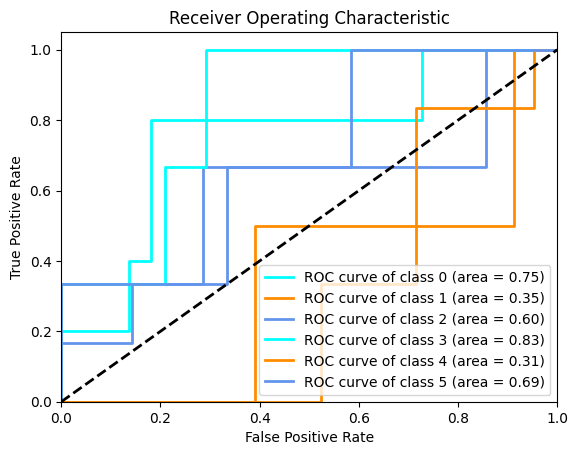

In [106]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import confusion_matrix, roc_curve, auc  
from sklearn.preprocessing import label_binarize  
from itertools import cycle  

  
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)  
  
models = {  
    "Random Forest": RandomForestClassifier(),  
    "Logistic Regression": LogisticRegression(),  
    "Naive Bayes": GaussianNB()  
}  
  
results = {}  
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
  
for name, model in models.items():  
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  
      
    cm = confusion_matrix(y_test, y_pred)  
    results[name + "_confusion_matrix"] = cm  
      
    if len(np.unique(y_test)) > 2:  
        y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))  
        n_classes = y_test_binarized.shape[1]  
        fpr = dict()  
        tpr = dict()  
        roc_auc = dict()  
        for i in range(n_classes):  
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], model.predict_proba(X_test)[:, i])  
            roc_auc[i] = auc(fpr[i], tpr[i])  
        results[name + "_auc"] = np.mean(list(roc_auc.values()))  
    else:  
        y_test_binarized = label_binarize(y_test, classes=[0, 1])  
        y_pred_proba = model.predict_proba(X_test)[:, 1]  
        fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba)  
        roc_auc = auc(fpr, tpr)  
        results[name + "_auc"] = roc_auc  
        results[name + "_fpr"] = fpr  
        results[name + "_tpr"] = tpr  
  
# # draw ROC line  
if any(len(np.unique(y_test)) > 2 for name, model in models.items()):  
    plt.figure()  
    for i, color in zip(range(n_classes), colors):  
        plt.plot(fpr[i], tpr[i], color=color, lw=2,  
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))  
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Receiver Operating Characteristic')  
    plt.legend(loc="lower right")  
else:  
    plt.figure()  
    for name, fpr, tpr, auc_score in [(k, results[k + "_fpr"], results[k + "_tpr"], results[k + "_auc"]) for k in results if "fpr" in k]:  
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc_score))  
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Receiver Operating Characteristic')  
    plt.legend(loc="lower right")  
  
plt.show()

In [123]:
results

{'Random Forest_confusion_matrix': array([[2, 0, 1, 1, 0, 1],
        [2, 0, 0, 0, 2, 0],
        [0, 3, 0, 2, 0, 1],
        [0, 0, 0, 0, 3, 0],
        [0, 0, 1, 2, 1, 2],
        [0, 1, 1, 0, 0, 1]], dtype=int64),
 'Random Forest_auc': 0.6521071219440785,
 'Logistic Regression_confusion_matrix': array([[0, 3, 0, 1, 0, 1],
        [2, 0, 0, 0, 1, 1],
        [0, 1, 2, 1, 0, 2],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 2, 0, 0, 3],
        [0, 0, 1, 0, 0, 2]], dtype=int64),
 'Logistic Regression_auc': 0.6279900453813497,
 'Naive Bayes_confusion_matrix': array([[1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 3, 1],
        [0, 2, 1, 0, 0, 3],
        [0, 0, 0, 0, 2, 1],
        [0, 1, 1, 1, 0, 3],
        [0, 0, 0, 0, 1, 2]], dtype=int64),
 'Naive Bayes_auc': 0.5891518706736097}

### Visualizing principal components

In [124]:
xy=[]
for a in names:
    xy_temp=pd.concat([x[a],y[a]],axis=1).values
    xy_temp2=xy_temp.flatten()
    xy.append(xy_temp2)
xy=pd.DataFrame(xy).transpose()
xy.columns=names

In [125]:
features=xy
n_samples, n_features = features.shape
mean = pd.Series(np.mean(features, axis=1))
centered_data = pd.DataFrame()
for a in names:
    centered_data_temp = features[a]-mean
    centered_data[a]=centered_data_temp
centered_data_t = centered_data.T

U, S, V = linalg.svd(features,full_matrices=False)

#### Mean profile form

Text(0.5, 1.0, 'Mean normalized scarp profile')

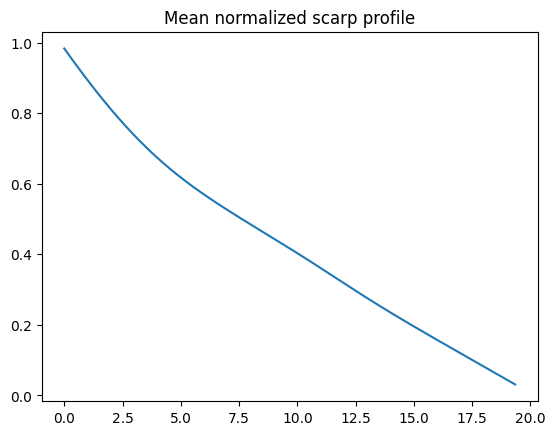

In [126]:
mean_2D=pd.DataFrame(mean.values.reshape((300,2)),columns=['x','y'])
plt.plot(mean_2D['x'],mean_2D['y'])
plt.title('Mean normalized scarp profile')

In [127]:
PCX=pd.DataFrame(U[0::2,:r_best])
PCY=pd.DataFrame(U[1::2,:r_best])

Text(0.5, 1.0, 'PC1')

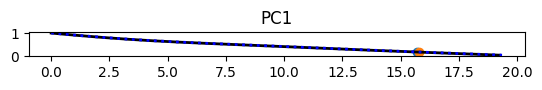

In [128]:
#PC1
PC1x = mean_2D['x']+PCX.iloc[:,0]
PC1y = mean_2D['y']+PCY.iloc[:,0]
fig,ax=plt.subplots()
ax.plot(PC1x,PC1y,'k',linewidth=2)
#ax.plot(x,y,'gray',linewidth=0.1)
ax.plot(mean_2D['x'],mean_2D['y'],'b:',linewidth=2)
ax.scatter(PC1x[260],PC1y[260])#,'k',linewidth=2)
ax.scatter(mean_2D['x'][260],mean_2D['y'][260])#,'k',linewidth=2)

#ax.plot(PCX.iloc[:,0],PCY.iloc[:,0],'r:')
ax.set_aspect('equal')
ax.set_title('PC1')

Text(0.5, 1.0, 'PC2')

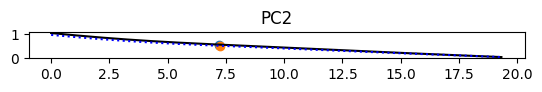

In [129]:
#PC2
PC2x = mean_2D['x']+PCX.iloc[:,1]
PC2y = mean_2D['y']+PCY.iloc[:,1]
fig,ax=plt.subplots()
ax.plot(PC2x,PC2y,'k')
ax.plot(mean_2D['x'],mean_2D['y'],'b:')
ax.scatter(PC2x[100],PC2y[100])#,'k',linewidth=2)
ax.scatter(mean_2D['x'][100],mean_2D['y'][100])#,'k',linewidth=2)
ax.set_aspect('equal')
ax.set_title('PC2')

In [130]:
mean_line=pd.Series((np.ones(300))*0)

Text(0.5, 1.0, 'PC3')

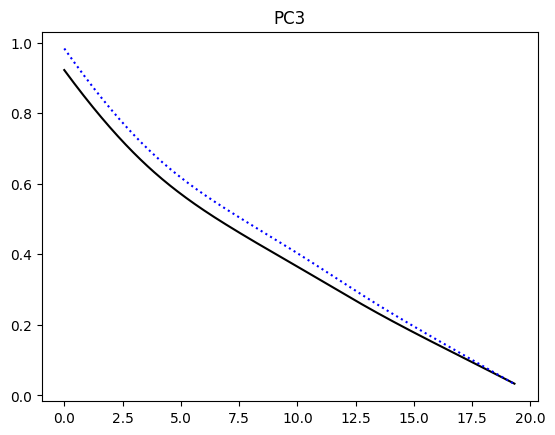

In [131]:
#PC3
PC3x = mean_2D['x']+PCX.iloc[:,2]
PC3y = mean_2D['y']+PCY.iloc[:,2]
fig,ax=plt.subplots()
ax.plot(PC3x,PC3y,'k')
ax.plot(mean_2D['x'],mean_2D['y'],'b:')
ax.set_title('PC3')

Text(0.5, 1.0, 'PC4')

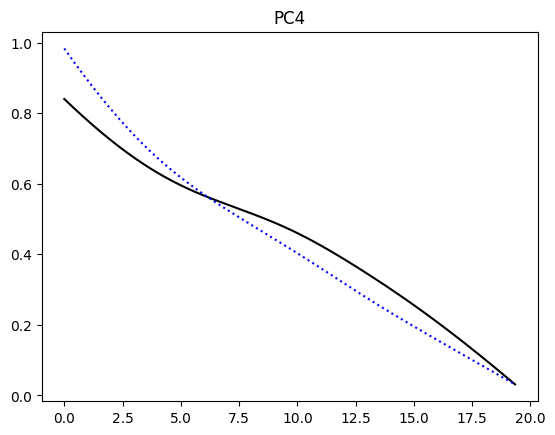

In [132]:
#PC4
PC4x = mean_2D['x']+PCX.iloc[:,3]
PC4y = mean_2D['y']+PCY.iloc[:,3]
fig,ax=plt.subplots()
ax.plot(PC4x,PC4y,'k')
ax.plot(mean_2D['x'],mean_2D['y'],'b:')
ax.set_title('PC4')

Text(0.5, 1.0, 'PC5')

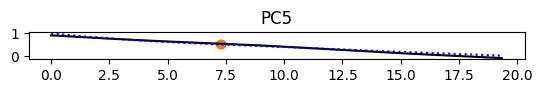

In [133]:
#PC5
PC5x = mean_2D['x']+PCX.iloc[:,4]
PC5y = mean_2D['y']+PCY.iloc[:,4]
fig,ax=plt.subplots()
ax.plot(PC5x,PC5y,'k')
ax.plot(mean_2D['x'],mean_2D['y'],'b:')
ax.scatter(PC5x[100],PC5y[100])#,'k',linewidth=2)
ax.scatter(mean_2D['x'][100],mean_2D['y'][100])
ax.set_aspect('equal')
ax.set_title('PC5')

Text(0.5, 1.0, 'PC6')

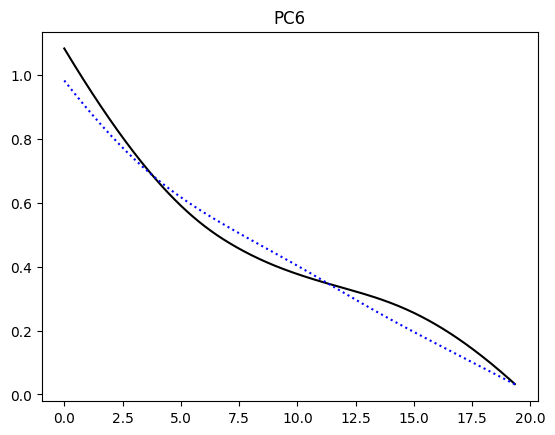

In [134]:
#PC6
PC6x = mean_2D['x']+PCX.iloc[:,5]
PC6y = mean_2D['y']+PCY.iloc[:,5]
fig,ax=plt.subplots()
ax.plot(PC6x,PC6y,'k')
ax.plot(mean_2D['x'],mean_2D['y'],'b:')
ax.set_title('PC6')

Text(0.5, 1.0, 'PC7')

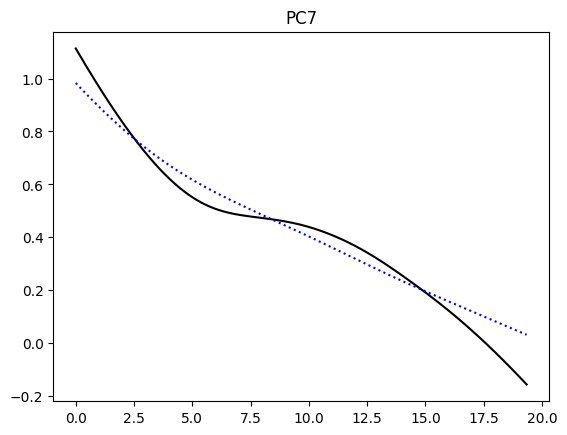

In [135]:
#PC7
PC7x = mean_2D['x']+PCX.iloc[:,6]
PC7y = mean_2D['y']+PCY.iloc[:,6]
fig,ax=plt.subplots()
ax.plot(PC7x,PC7y,'k')
ax.plot(mean_2D['x'],mean_2D['y'],'b:')
ax.set_title('PC7')

In [ ]:
#PC8
PC8x = mean_2D['x']+PCX.iloc[:,7]
PC8y = mean_2D['y']+PCY.iloc[:,7]
fig,ax=plt.subplots()
ax.plot(PC8x,PC8y,'k')
ax.plot(mean_2D['x'],mean_2D['y'],'b:')
ax.set_title('PC8')